In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import seaborn as sns
from pprint import pprint

In [13]:
os.chdir(r"C:\Users\parzi\OneDrive - Tribhuvan University\Desktop\Major Project\CODE\BCS Code\BCS-ALL-Code\Crossword Solver")

In [16]:
glob.glob('./Result and Analysis Section/Second pass model outputs/*.txt')

['./Result and Analysis Section/Second pass model outputs\\ByT5 Console Output.txt',
 './Result and Analysis Section/Second pass model outputs\\byt5 multi iteration data.txt',
 './Result and Analysis Section/Second pass model outputs\\T5 Console Output.txt',
 './Result and Analysis Section/Second pass model outputs\\t5 multi iteration data segmented answer model.txt',
 './Result and Analysis Section/Second pass model outputs\\t5 multi iteration data segmented answer model_2.txt',
 './Result and Analysis Section/Second pass model outputs\\t5 multi iteration data word segmented.txt',
 './Result and Analysis Section/Second pass model outputs\\t5 multi iteration data.txt',
 './Result and Analysis Section/Second pass model outputs\\t5 training output.txt',
 './Result and Analysis Section/Second pass model outputs\\t5_small on all dataset training.txt']

In [17]:
def extract_float(input_string):
    pattern = r"\d+\.\d+"
    matches = re.findall(pattern, input_string)
    float_numbers = [float(match) for match in matches]
    return float_numbers

In [18]:
def get_mean_data(F_NAME):
    # F_NAME = "byt5 multi iteration data.txt"
    with open(F_NAME, 'r') as f:
        lines = f.readlines()
    date_pattern = r"\b\d{2}/\d{2}/\d{4}\b"
    data_dict = {}
    new_date_math = False
    current_date = ''

    for line in lines:
        match = re.match(date_pattern, line) # to match the date pattern

        if match:
            current_date = line.strip()
            data_dict[current_date] = {}
            data_dict[current_date]['Letter II'] = []
            data_dict[current_date]['Word II'] = []

        if 'Before' in line:
            [lett_accu, word_accu] = extract_float(line)
            data_dict[current_date]['Before Letter Accuracy'] = lett_accu
            data_dict[current_date]['Before Word Accuracy'] = word_accu

        if 'iteration:' in line:
            lett_accu, word_accu = extract_float(line)
            data_dict[current_date]['Letter II'].append(lett_accu)
            data_dict[current_date]['Word II'].append(word_accu)
            
    max_length = 0
    for key, value in data_dict.items():
        if len(value['Letter II']) > max_length:
            max_length = len(value['Letter II'])
            
    # extending all the letter and word accuracy float values to the maxm length
    for key, value in data_dict.items():
        if len(value['Letter II']) < max_length:
            last_lett_accu = value['Letter II'][-1]
            last_word_accu = value['Word II'][-1]
            for i in range(max_length - len(value['Letter II'])):
                data_dict[key]['Letter II'].append(last_lett_accu)
                data_dict[key]['Word II'].append(last_word_accu)

    all_letter_accu_list = []
    all_word_accu_list = []

    for key, value in data_dict.items():
        letter_accu_list = value['Letter II'].copy()
        letter_accu_list.insert(0, value['Before Letter Accuracy'])
        all_letter_accu_list.append(letter_accu_list)

        word_accu_list = value['Word II'].copy()
        word_accu_list.insert(0, value['Before Word Accuracy'])
        all_word_accu_list.append(word_accu_list)
    
    all_letter_accu = np.array(all_letter_accu_list)
    all_word_accu = np.array(all_word_accu_list)
    avg_letter_accu = np.mean(all_letter_accu, axis = 0)
    avg_word_accu = np.mean(all_word_accu, axis = 0)
    
    return avg_letter_accu, avg_word_accu

#### T5_small trained on 3M dataset for 2 epoch vs ByT5_small Model

In [22]:
byt5_letter_list, byt5_word_list = get_mean_data("./Result and Analysis Section/Second pass model outputs/byt5 multi iteration data.txt")
t5_letter_list, t5_word_list = get_mean_data("./Result and Analysis Section/Second pass model outputs/t5 multi iteration data word segmented.txt")
t5_letter_list_1, t5_word_list_1 = get_mean_data("./Result and Analysis Section/Second pass model outputs/t5 multi iteration data.txt")

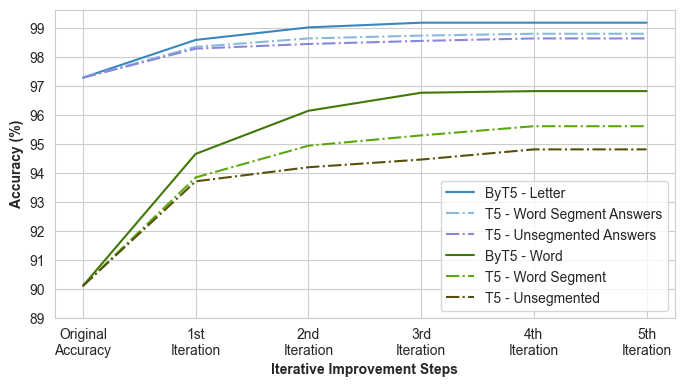

In [24]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(byt5_letter_list, label = 'ByT5 - Letter', color = (56/255, 135/255, 190/255))
plt.plot(t5_letter_list, label = 'T5 - Word Segment Answers', linestyle = '-.', color = (137/255, 185/255, 220/255))
plt.plot(t5_letter_list_1, label = 'T5 - Unsegmented Answers', linestyle = '-.', color = (137/255, 135/255, 220/255))


plt.plot(byt5_word_list, label = 'ByT5 - Word', color = (64/255, 120/255, 7/255))
plt.plot(t5_word_list, label = 'T5 - Word Segment', linestyle = '-.', color = (89/255, 169/255, 10/255))
plt.plot(t5_word_list_1, label = 'T5 - Unsegmented', linestyle = '-.', color = (89/255, 79/255, 10/255))
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))
plt.xlabel("Iterative Improvement Steps", font = {'weight':'bold'})
plt.ylabel("Accuracy (%)", font = {'weight':'bold'})
# plt.title("Byt5 as Second Pass Model")
plt.show()

#### T5_small trained one full epoch with 64 batch size, with segmented answers

In [ ]:
byt5_letter_list, byt5_word_list = get_mean_data("./Second pass model outputs/byt5 multi iteration data.txt")
t5_letter_list, t5_word_list = get_mean_data("./Second pass model outputs/t5 multi iteration data.txt")

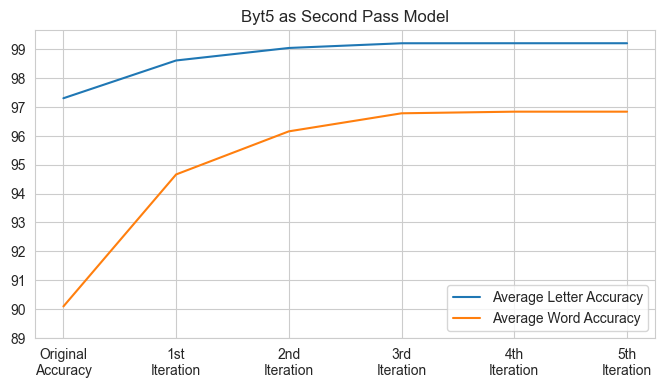

In [110]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(byt5_letter_list, label = 'Average Letter Accuracy')
plt.plot(byt5_word_list, label = 'Average Word Accuracy')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))

plt.title("Byt5 as Second Pass Model")
plt.show()

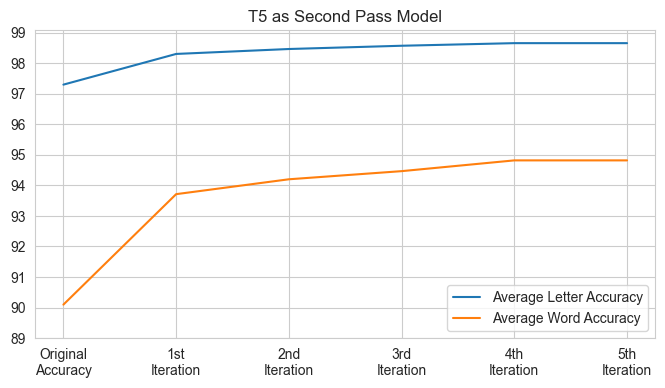

In [112]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(t5_letter_list, label = 'Average Letter Accuracy')
plt.plot(t5_word_list, label = 'Average Word Accuracy')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))

plt.title("T5 as Second Pass Model")
plt.show()

#### Comparison between ByT5 and T5

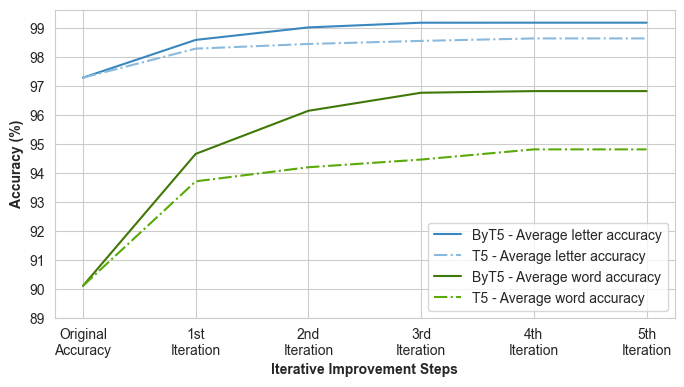

In [146]:
# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(byt5_letter_list, label = 'ByT5 - Average letter accuracy', color = (56/255, 135/255, 190/255))
plt.plot(t5_letter_list, label = 'T5 - Average letter accuracy', linestyle = '-.', color = (137/255, 185/255, 220/255))

plt.plot(byt5_word_list, label = 'ByT5 - Average word accuracy', color = (64/255, 120/255, 7/255))
plt.plot(t5_word_list, label = 'T5 - Average word accuracy', linestyle = '-.', color = (89/255, 169/255, 10/255))
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))
plt.xlabel("Iterative Improvement Steps", font = {'weight':'bold'})
plt.ylabel("Accuracy (%)", font = {'weight':'bold'})
# plt.title("Byt5 as Second Pass Model")
plt.show()

#### T5_small trained with segmented answer and tokenizer set to 32 sequence length for both input (clue) & label (answer)

['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration', '6th\nIteration', '7th\nIteration', '8th\nIteration']


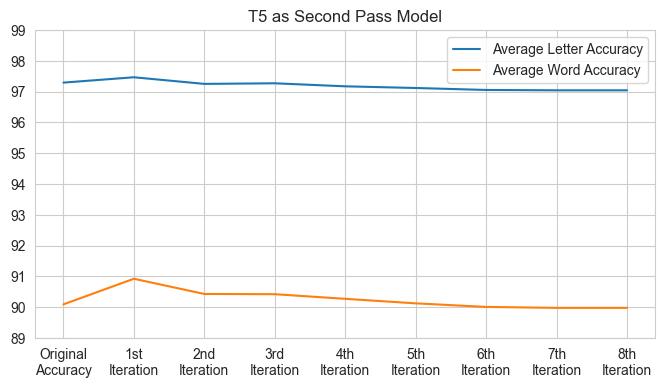

In [166]:
t5_letter_list_1, t5_word_list_1 = get_mean_data("./Second pass model outputs/t5 multi iteration data segmented answer model.txt")

# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(t5_letter_list_1, label = 'Average Letter Accuracy')
plt.plot(t5_word_list_1, label = 'Average Word Accuracy')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration']
for i in range(4, len(t5_letter_list_1)):
    custom_xticks.append(f"{i}th\nIteration")
    
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))

plt.title("T5 as Second Pass Model")
plt.show()

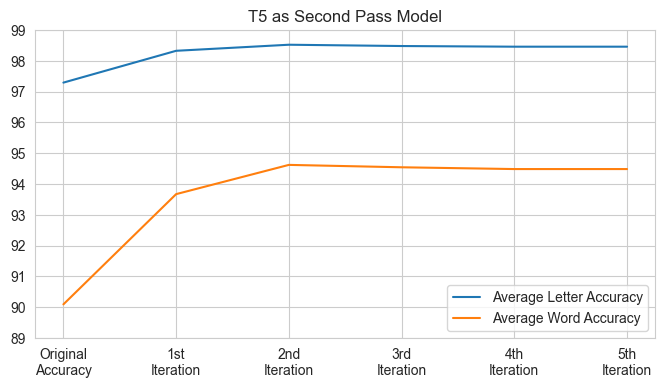

In [167]:
t5_letter_list_1, t5_word_list_1 = get_mean_data("./Second pass model outputs/t5 multi iteration data segmented answer model_2.txt")

# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(t5_letter_list_1, label = 'Average Letter Accuracy')
plt.plot(t5_word_list_1, label = 'Average Word Accuracy')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration']
for i in range(4, len(t5_letter_list_1)):
    custom_xticks.append(f"{i}th\nIteration")
    
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))

plt.title("T5 as Second Pass Model")
plt.show()

#### Analyzing all the T5_small model iterative ability

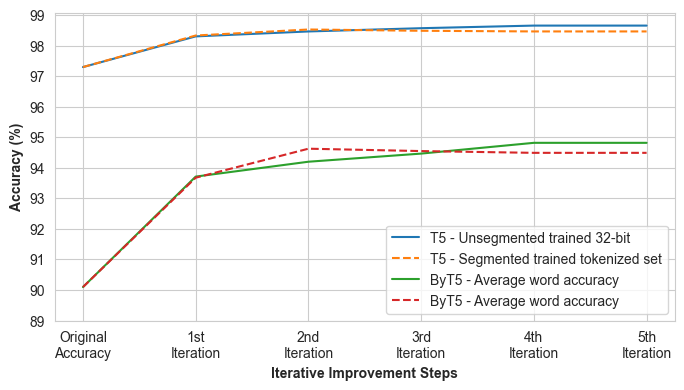

In [171]:
t5_letter_list_0, t5_word_list_0 = get_mean_data("./Second pass model outputs/t5 multi iteration data.txt")
t5_letter_list_1, t5_word_list_1 = get_mean_data("./Second pass model outputs/t5 multi iteration data segmented answer model.txt")
t5_letter_list_2, t5_word_list_2 = get_mean_data("./Second pass model outputs/t5 multi iteration data segmented answer model_2.txt")

# BYT5 graphical analysis on the iterative improvement steps
sns.set_style('whitegrid')
plt.figure(figsize = (8, 4))

plt.plot(t5_letter_list_0, label = 'T5 - Unsegmented trained 32-bit')
# plt.plot(t5_letter_list_1, label = 'T5 - Average letter accuracy', linestyle = '-.')
plt.plot(t5_letter_list_2, label = 'T5 - Segmented trained tokenized set', linestyle = '--')

plt.plot(t5_word_list_0, label = 'ByT5 - Average word accuracy')
# plt.plot(t5_word_list_1, label = 'ByT5 - Average word accuracy', linestyle = '-.')
plt.plot(t5_word_list_2, label = 'ByT5 - Average word accuracy', linestyle = '--')
plt.legend(loc = 'best')

custom_xticks = ['Original\nAccuracy', '1st\nIteration', '2nd\nIteration', '3rd\nIteration', '4th\nIteration', '5th\nIteration']
plt.xticks(range(len(custom_xticks)), custom_xticks)
plt.yticks(np.arange(89, 100, 1))
plt.xlabel("Iterative Improvement Steps", font = {'weight':'bold'})
plt.ylabel("Accuracy (%)", font = {'weight':'bold'})
# plt.title("Byt5 as Second Pass Model")
plt.show()

<b>In every test upto this point, t5_small performed bad in compared to the byt5_small fine-tuned from the BCS. So, a possible improved training strategy could be to train the t5_small again without using sequence length restriction. 